In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [26]:
!git clone https://github.com/tprest/falcon.py.git
%cd falcon.py

fatal: destination path 'falcon.py' already exists and is not an empty directory.
[Errno 20] Not a directory: 'falcon.py'
/content/falcon.py


In [27]:
import os
import pandas as pd
import pydicom
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pywt
import falcon
import time
from PIL import Image
import io
import hashlib
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from skimage.metrics import mean_squared_error, peak_signal_noise_ratio, structural_similarity
from prettytable import PrettyTable
from scipy import ndimage
import torch
from pytorch_wavelets import DWTForward, DWTInverse # GPU DWT
import concurrent.futures

In [28]:
dataset_path = "/content/drive/MyDrive/6810_Project/datasets/archive/overview.csv"

dicom_dir = "/content/drive/MyDrive/6810_Project/datasets/archive/dicom_dir"

In [29]:
metadata = pd.read_csv(os.path.join(dataset_path))

In [31]:
# hyperparam config, AES-256 32 bytes size
WAVELET = 'haar'
TARGET_SIZE = (256, 256)
FALCON_N = 512
AES_KEY_SIZE = 32

In [32]:
def load_dicom_image(file_path):
    try:
        dicom = pydicom.dcmread(file_path)
        image = dicom.pixel_array
        if image.ndim > 2:
            print(f"Warning: Image {os.path.basename(file_path)} has {image.ndim} dimensions. Using first frame/channel.")
            if image.ndim == 3:
                if image.shape[-1] in [3, 4]:
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
                else:
                    image = image[0]
            elif image.ndim == 4:
                image = cv2.cvtColor(image[0], cv2.COLOR_BGR2GRAY)
            else:
                image = image.reshape(image.shape[-2], image.shape[-1])

        if image.dtype != np.uint8:
            min_val, max_val = np.min(image), np.max(image)
            if max_val > min_val:
                image = ((image - min_val) / (max_val - min_val) * 255.0).astype(np.uint8)
            else:
                image = np.zeros_like(image, dtype=np.uint8)
        return image
    except FileNotFoundError:
        print(f"Error: DICOM file not found at {file_path}")
        return None
    except Exception as e:
        print(f"Error loading DICOM file {file_path}: {e}")
        return None

In [33]:
def preprocess_image(image, target_size=TARGET_SIZE):
    if image is None:
        return None
    try:
        image_resized = cv2.resize(image, target_size, interpolation=cv2.INTER_AREA)
        image_normalized = image_resized.astype(np.float32) / 255.0
        return image_normalized
    except Exception as e:
        print(f"Error preprocessing image: {e}")
        return None

Region-based adaptive processing to specific areas of the image using edge detection (Canny) and contour finding to indentify the regions

In [34]:
def detect_sensitive_regions(image_np_uint8, edge_thresh_low=100, edge_thresh_high=200, min_area_ratio=0.01):
    if image_np_uint8 is None:
        print("Error: Input image for region detection is None.")
        return []
    if image_np_uint8.ndim == 3:
        gray = cv2.cvtColor(image_np_uint8, cv2.COLOR_BGR2GRAY)
    elif image_np_uint8.dtype != np.uint8:
        min_val, max_val = np.min(image_np_uint8), np.max(image_np_uint8)
        if max_val > min_val:
            gray = ((image_np_uint8 - min_val) / (max_val - min_val) * 255.0).astype(np.uint8)
        else:
            gray = np.zeros_like(image_np_uint8, dtype=np.uint8)
    else:
        gray = image_np_uint8

    edges = cv2.Canny(gray, edge_thresh_low, edge_thresh_high)

    kernel = np.ones((3,3), np.uint8)
    dilated_edges = cv2.dilate(edges, kernel, iterations=1)

    contours, _ = cv2.findContours(dilated_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    regions = []
    img_area = gray.shape[0] * gray.shape[1]
    if img_area == 0: return []
    min_absolute_area = img_area * min_area_ratio

    for contour in contours:
        area = cv2.contourArea(contour)
        if area > min_absolute_area:
            x, y, w, h = cv2.boundingRect(contour)
            x = max(0, x)
            y = max(0, y)
            w = min(gray.shape[1] - x, w)
            h = min(gray.shape[0] - y, h)
            if w > 0 and h > 0:
                regions.append((x, y, w, h))

    if not regions:
        print("No specific regions detected based on edges.")
        h_img, w_img = gray.shape[:2]
        cx, cy = w_img // 2, h_img // 2
        size_w, size_h = w_img // 4, h_img // 4
        x_c, y_c = max(0, cx - size_w // 2), max(0, cy - size_h // 2)
        w_c, h_c = min(w_img - x_c, size_w), min(h_img - y_c, size_h)
        if w_c > 0 and h_c > 0: regions.append((x_c, y_c, w_c, h_c))

    return regions

GPU-Accelerated DWT

In [35]:
def dwt_2d(image):
    coeffs = pywt.wavedec2(image, 'haar', level=1)
    coeff_arr, coeff_slices = pywt.coeffs_to_array(coeffs)
    return coeff_arr, coeff_slices

In [36]:
def idwt_2d(coeff_arr, coeff_slices):
    coeffs = pywt.array_to_coeffs(coeff_arr, coeff_slices, output_format='wavedec2')
    return pywt.waverec2(coeffs, 'haar')

In [37]:
def dwt_2d_with_subbands(image, wavelet='haar', level=1):
    coeffs = pywt.wavedec2(image, wavelet, level=level)
    cA = coeffs[0]
    (cH, cV, cD) = coeffs[1]
    return cA, cH, cV, cD

TO keep image quality and texture after reconstruction

In [38]:
def idwt_2d_from_subbands(cA, cH, cV, cD, wavelet=WAVELET):
    """Reconstructs image from DWT sub-bands"""
    coeffs = [cA, (cH, cV, cD)]
    return pywt.waverec2(coeffs, wavelet)

In [41]:
def dwt_2d_gpu(image_tensor, wavelet=WAVELET, level=1, device='cuda'):
    xfm = DWTForward(J=level, wave=wavelet, mode='zero').to(device)
    # Input format: (N, C, H, W)
    if image_tensor.ndim == 2:
        image_tensor = image_tensor.unsqueeze(0).unsqueeze(0)
    elif image_tensor.ndim == 3:
        image_tensor = image_tensor.unsqueeze(0)

    yl, yh = xfm(image_tensor)
    # yl: Low-pass (Approximation) - Shape (N, C, H/2, W/2)
    # yh: High-pass band tensors [(N, C, 3, H/2, W/2)] level 1
    # For level 1, yh[0] contains LH, HL, HH bands stacked on dim 2
    yh_bands = yh[0] # Shape (N, C, 3, H/2, W/2)
    cA = yl # Approximation coefficients
    cH = yh_bands[:, :, 0, :, :] # Horizontal detail
    cV = yh_bands[:, :, 1, :, :] # Vertical detail
    cD = yh_bands[:, :, 2, :, :] # Diagonal detail
    if image_tensor.shape[0] == 1 and image_tensor.shape[1] == 1:
         return cA.squeeze(0).squeeze(0), cH.squeeze(0).squeeze(0), cV.squeeze(0).squeeze(0), cD.squeeze(0).squeeze(0)
    else:
         return cA, cH, cV, cD

In [42]:
def idwt_2d_gpu(cA, cH, cV, cD, wavelet=WAVELET, device='cuda'):
    ifm = DWTInverse(wave=wavelet, mode='zero').to(device)
    # Input batch and channel dims (N, C, H, W)
    if cA.ndim == 2: cA = cA.unsqueeze(0).unsqueeze(0)
    if cH.ndim == 2: cH = cH.unsqueeze(0).unsqueeze(0)
    if cV.ndim == 2: cV = cV.unsqueeze(0).unsqueeze(0)
    if cD.ndim == 2: cD = cD.unsqueeze(0).unsqueeze(0)

    # yh input: (N, C, 3, H, W)
    yh_bands = torch.stack([cH, cV, cD], dim=2)
    yh = [yh_bands]

    reconstructed_tensor = ifm((cA, yh))
    if reconstructed_tensor.shape[0] == 1 and reconstructed_tensor.shape[1] == 1:
        return reconstructed_tensor.squeeze(0).squeeze(0)
    else:
        return reconstructed_tensor

FALCON Post Quantum Singature

In [45]:
def generate_falcon_keys(n=FALCON_N):
    try:
        sk = falcon.SecretKey(n)
        pk = falcon.PublicKey(sk)
        return sk, pk
    except Exception as e:
        print(f"Error generating Falcon keys: {e}")
        return None, None

In [47]:
def sign_data_falcon(data_bytes, sk):
    if sk is None or data_bytes is None:
        return None
    try:
         signature = sk.sign(data_bytes)
         return signature
    except Exception as e:
         print(f"Falcon signing failed: {e}")
         return None

In [48]:
def verify_signature_falcon(data_bytes, signature, pk):
    if pk is None or data_bytes is None or signature is None:
        return False
    try:
        return pk.verify(data_bytes, signature)
    except Exception as e:
        print(f"Falcon verification failed: {e}")
        return False

In [49]:
def encrypt_aes_gcm(data_bytes, key):
    if key is None or data_bytes is None:
        return None, None, None
    try:
        cipher = AES.new(key, AES.MODE_GCM) # GCM provides auth tag
        nonce = cipher.nonce
        ciphertext, tag = cipher.encrypt_and_digest(data_bytes)
        print(f"AES-GCM Encrypted {len(data_bytes)} bytes -> {len(ciphertext)} bytes ciphertext.")
        return ciphertext, nonce, tag
    except Exception as e:
        print(f"AES-GCM encryption failed: {e}")
        return None, None, None

In [50]:
def decrypt_aes_gcm(ciphertext, nonce, tag, key):
    if key is None or ciphertext is None or nonce is None or tag is None:
        return None
    try:
        cipher = AES.new(key, AES.MODE_GCM, nonce=nonce)
        decrypted_data = cipher.decrypt_and_verify(ciphertext, tag)
        print(f"AES-GCM Decrypted {len(ciphertext)} bytes -> {len(decrypted_data)} bytes.")
        return decrypted_data
    except ValueError:
        print("AES GCM Decryption/Verification failed (MAC check failed or invalid ciphertext)")
        return None
    except Exception as e:
        print(f"AES GCM Decryption failed: {e}")
        return None

In [51]:
def calculate_metrics(original_image_np, reconstructed_image_np):
    if original_image_np is None or reconstructed_image_np is None:
        print("Error: Cannot calculate metrics with None input.")
        return {"MSE": float('inf'), "PSNR": 0.0, "SSIM": 0.0}
    if original_image_np.shape != reconstructed_image_np.shape:
        print("Error: Image shapes mismatch for metrics calculation.")
        return {"MSE": float('inf'), "PSNR": 0.0, "SSIM": 0.0}

    original_image_np = original_image_np.astype(np.float32)
    reconstructed_image_np = reconstructed_image_np.astype(np.float32)

    mse = mean_squared_error(original_image_np, reconstructed_image_np)

    # Calculate PSNR
    # data_range is max_pixel_value - min_pixel_value. For [0,1] normalized, it's 1.0
    psnr = peak_signal_noise_ratio(original_image_np, reconstructed_image_np, data_range=1.0)

    # Calculate SSIM
    # Ensure data_range is set. win_size should be odd and smaller than image dimensions.
    win_size = min(7, original_image_np.shape[0] // 2 * 2 + 1, original_image_np.shape[1] // 2 * 2 + 1)
    if win_size < 3:
        print("Warning: Image too small for default SSIM window size. Skipping SSIM.")
        ssim = 0.0 # Or handle differently
    else:
        ssim = structural_similarity(original_image_np, reconstructed_image_np, data_range=1.0, win_size=win_size, channel_axis=None)

    return {"MSE": mse, "PSNR": psnr, "SSIM": ssim}

Parallelization Process

In [52]:
def process_parallelization(args):
    idx, row, dicom_dir, target_size, wavelet, falcon_sk, falcon_pk, num_images_to_display = args

    if 'dicom_name' not in row:
        print(f"Skipping row {idx} due to missing 'dicom_name' column.")
        return None, None

    dicom_filename = row['dicom_name']
    dicom_path = os.path.join(dicom_dir, dicom_filename)
    print(f"--- Processing Image {idx + 1}: {dicom_filename} ---")
    img_start_time = time.time()
    times = {}
    result_data = {'image_index': idx, 'filename': dicom_filename}
    visualization_data = None

    try:
        # Load & Preprocess
        prep_start_time = time.time()
        raw_image_uint8 = load_dicom_image(dicom_path)
        if raw_image_uint8 is None:
            print(f"Skipping {dicom_filename} due to loading error.")
            result_data.update({'status': 'Load Error', 'time_sec': time.time() - img_start_time})
            return result_data, None

        processed_image_float = preprocess_image(raw_image_uint8, target_size)
        if processed_image_float is None:
            print(f"Skipping {dicom_filename} due to preprocessing error.")
            result_data.update({'status': 'Preproc Error', 'time_sec': time.time() - img_start_time})
            return result_data, None

        processed_image_uint8 = (processed_image_float * 255).astype(np.uint8) # For region detection/display
        prep_end_time = time.time()
        times['load_prep_sec'] = prep_end_time - prep_start_time

        # Detect Regions
        detect_start_time = time.time()
        regions = detect_sensitive_regions(processed_image_uint8)
        detect_end_time = time.time()
        times['detect_regions_sec'] = detect_end_time - detect_start_time
        result_data['regions_detected'] = len(regions)
        #print(f"Detected {len(regions)} sensitive regions.")

        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        if device == 'cpu':
            print(f"Warning: CUDA not available for image {idx+1}, GPU acceleration disabled.")
        image_tensor = torch.from_numpy(processed_image_float).to(device)

        # GPU-accelerate DWT
        dwt_start_time = time.time()
        cA_gpu, cH_gpu, cV_gpu, cD_gpu = dwt_2d_gpu(image_tensor, wavelet=wavelet, device=device)
        dwt_end_time = time.time()
        times['dwt_sec'] = dwt_end_time - dwt_start_time

        # Encryption/Signing
        cA_processed = cA_gpu.clone()
        region_security_data = []
        enc_sign_start_time = time.time()
        num_regions_secured = 0
        for r_idx, (x, y, w, h) in enumerate(regions):
            # Map spatial region to DWT coefficient region
            scale_x = cA_gpu.shape[1] / target_size[1]
            scale_y = cA_gpu.shape[0] / target_size[0]
            ll_x, ll_y = int(x * scale_x), int(y * scale_y)
            ll_w, ll_h = max(1, int(w * scale_x)), max(1, int(h * scale_y))

            # Clamp coordinates
            ll_x = max(0, min(ll_x, cA_gpu.shape[1] - 1))
            ll_y = max(0, min(ll_y, cA_gpu.shape[0] - 1))
            if ll_x + ll_w > cA_gpu.shape[1]: ll_w = cA_gpu.shape[1] - ll_x
            if ll_y + ll_h > cA_gpu.shape[0]: ll_h = cA_gpu.shape[0] - ll_y

            if ll_w <= 0 or ll_h <= 0: continue

            ll_region_coeffs = cA_gpu[ll_y:ll_y + ll_h, ll_x:ll_x + ll_w]
            original_ll_region_shape = ll_region_coeffs.shape
            ll_region_bytes = ll_region_coeffs.cpu().numpy().tobytes()

            aes_key = get_random_bytes(AES_KEY_SIZE)
            aes_key_signature = sign_data_falcon(aes_key, falcon_sk)
            if aes_key_signature is None: continue

            encrypted_data = encrypt_aes_gcm(ll_region_bytes, aes_key)
            if encrypted_data is None: continue
            ciphertext, nonce, tag = encrypted_data

            region_data = { 'coords': (ll_y, ll_x, ll_h, ll_w), 'original_shape': original_ll_region_shape,
                            'ciphertext': ciphertext, 'nonce': nonce, 'tag': tag,
                            'aes_key_signature': aes_key_signature, 'aes_key': aes_key }
            region_security_data.append(region_data)
            num_regions_secured += 1

        enc_sign_end_time = time.time()
        times['enc_sign_sec'] = enc_sign_end_time - enc_sign_start_time
        result_data['regions_secured'] = num_regions_secured

        # Reconstruction/Decryption
        recon_start_time = time.time()
        verification_failures = 0
        decryption_failures = 0
        cA_reconstructed = cA_gpu.clone()

        simulate_attack_here = False
        if idx == 0 and num_regions_secured > 0:
            simulate_attack_here = True
            original_sig = region_security_data[0]['aes_key_signature']
            tampered_sig = bytearray(original_sig); tampered_sig[0] ^= 0xFF
            region_security_data[0]['aes_key_signature'] = bytes(tampered_sig)

        for region_data in region_security_data:
            ll_y, ll_x, ll_h, ll_w = region_data['coords']
            aes_key = region_data['aes_key']
            signature = region_data['aes_key_signature']

            verified = verify_signature_falcon(aes_key, signature, falcon_pk)
            if not verified:
                verification_failures += 1
                cA_reconstructed[ll_y:ll_y + ll_h, ll_x:ll_x + ll_w] = torch.zeros(region_data['original_shape'], device=device)
                continue

            decrypted_bytes = decrypt_aes_gcm(region_data['ciphertext'], region_data['nonce'], region_data['tag'], aes_key)
            if decrypted_bytes is None:
                decryption_failures += 1
                cA_reconstructed[ll_y:ll_y + ll_h, ll_x:ll_x + ll_w] = torch.zeros(region_data['original_shape'], device=device)
                continue

            try:
                decrypted_coeffs_np = np.frombuffer(decrypted_bytes, dtype=np.float32)
                decrypted_coeffs_tensor = torch.from_numpy(decrypted_coeffs_np).reshape(region_data['original_shape']).to(device)
                cA_reconstructed[ll_y:ll_y + ll_h, ll_x:ll_x + ll_w] = decrypted_coeffs_tensor
            except Exception as e:
                print(f"    (Image {idx+1}) ERROR reshaping/placing decrypted region [{ll_x},{ll_y}]: {e}")
                decryption_failures += 1
                cA_reconstructed[ll_y:ll_y + ll_h, ll_x:ll_x + ll_w] = torch.zeros(region_data['original_shape'], device=device)


        # Inverse DWT
        idwt_start_time = time.time()
        reconstructed_image_tensor = idwt_2d_gpu(cA_reconstructed, cH_gpu, cV_gpu, cD_gpu, wavelet=wavelet, device=device)
        idwt_end_time = time.time()
        times['idwt_sec'] = idwt_end_time - idwt_start_time
        times['reconstruction_sec'] = idwt_end_time - recon_start_time

        reconstructed_image_float = reconstructed_image_tensor.cpu().numpy()

        metrics_start_time = time.time()
        metrics = calculate_metrics(processed_image_float, reconstructed_image_float)
        metrics_end_time = time.time()
        times['metrics_sec'] = metrics_end_time - metrics_start_time

        img_proc_time = time.time() - img_start_time
        times['total_img_sec'] = img_proc_time

        result_data.update({
            'status': 'Success',
            'MSE': metrics['MSE'], 'PSNR': metrics['PSNR'], 'SSIM': metrics['SSIM'],
            'verification_failures': verification_failures,
            'decryption_failures': decryption_failures,
            'time_sec': img_proc_time,
            'time_details': times
        })

        if idx < num_images_to_display:
            visualization_data = {
                'idx': idx,
                'filename': dicom_filename,
                'original': processed_image_uint8,
                'reconstructed': np.clip(reconstructed_image_float, 0.0, 1.0),
                'regions': regions,
                'metrics': metrics,
                'regions_secured': num_regions_secured
            }
        return result_data, visualization_data

    except FileNotFoundError as e:
        print(f"******** ERROR (Image {idx+1}): File not found for {dicom_filename} ******** Path: {dicom_path} | Error: {e}")
        result_data.update({'status': 'File Not Found', 'time_sec': time.time() - img_start_time})
        return result_data, None
    except Exception as e:
        import traceback
        print(f"******** UNEXPECTED ERROR processing {dicom_filename} (Image {idx+1}) ********")
        print(f"Error type: {type(e).__name__} | Error message: {e}")
        print("Traceback:")
        traceback.print_exc()
        result_data.update({'status': f'Error: {type(e).__name__}', 'time_sec': time.time() - img_start_time})
        return result_data, None

 LL (approximation) sub-band coefficients to detect regions to ensure high quality.
 Loseless DWT

Starting main processing pipeline with Parallel Execution...
Generated Falcon-512 keys successfully.
Submitting 100 image processing tasks to ThreadPoolExecutor...
--- Processing Image 1: ID_0000_AGE_0060_CONTRAST_1_CT.dcm ---
--- Processing Image 2: ID_0001_AGE_0069_CONTRAST_1_CT.dcm ---
--- Processing Image 3: ID_0002_AGE_0074_CONTRAST_1_CT.dcm ---
--- Processing Image 4: ID_0003_AGE_0075_CONTRAST_1_CT.dcm ---
--- Processing Image 5: ID_0004_AGE_0056_CONTRAST_1_CT.dcm ---
--- Processing Image 6: ID_0005_AGE_0048_CONTRAST_1_CT.dcm ---
AES-GCM Encrypted 9728 bytes -> 9728 bytes ciphertext.
AES-GCM Encrypted 8192 bytes -> 8192 bytes ciphertext.
AES-GCM Encrypted 9500 bytes -> 9500 bytes ciphertext.
AES-GCM Encrypted 8704 bytes -> 8704 bytes ciphertext.
AES-GCM Encrypted 10240 bytes -> 10240 bytes ciphertext.
AES-GCM Encrypted 40016 bytes -> 40016 bytes ciphertext.
AES-GCM Decrypted 9500 bytes -> 9500 bytes.
AES-GCM Decrypted 40016 bytes -> 40016 bytes.
AES-GCM Encrypted 51660 bytes -> 5

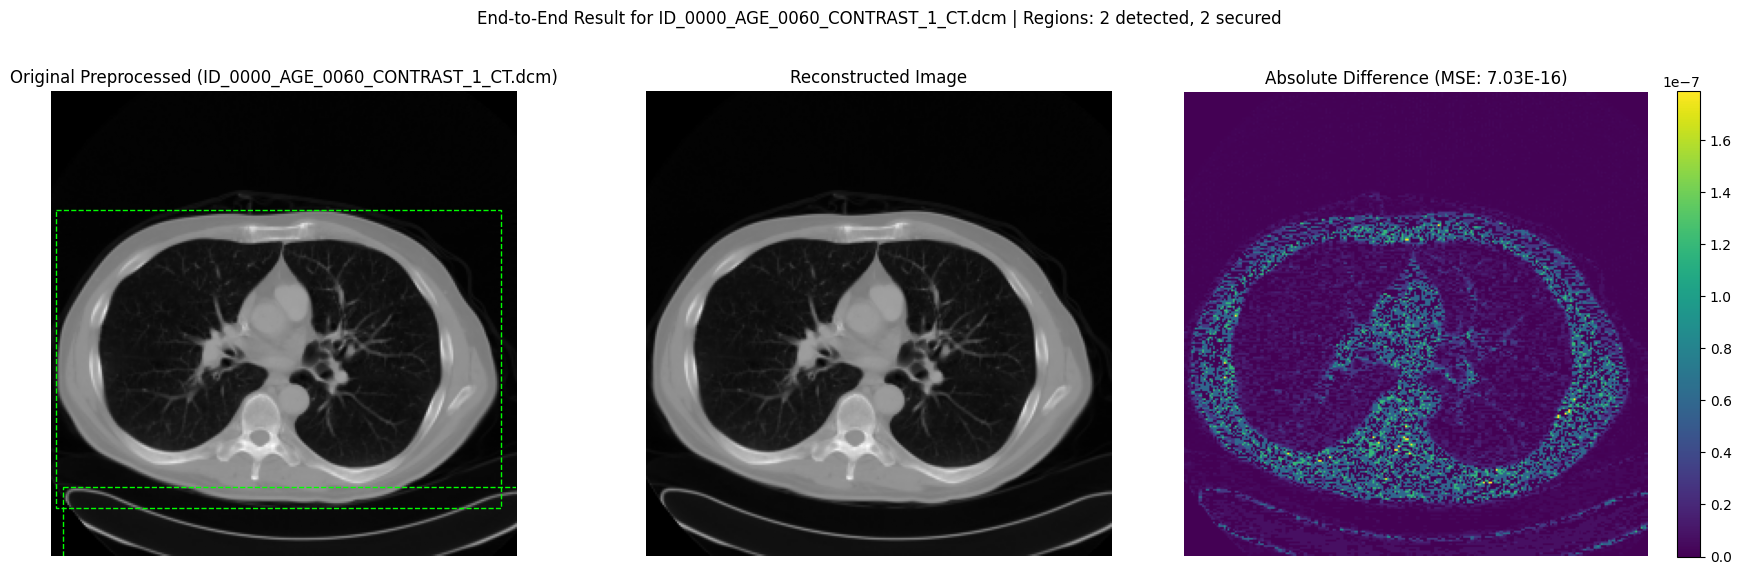

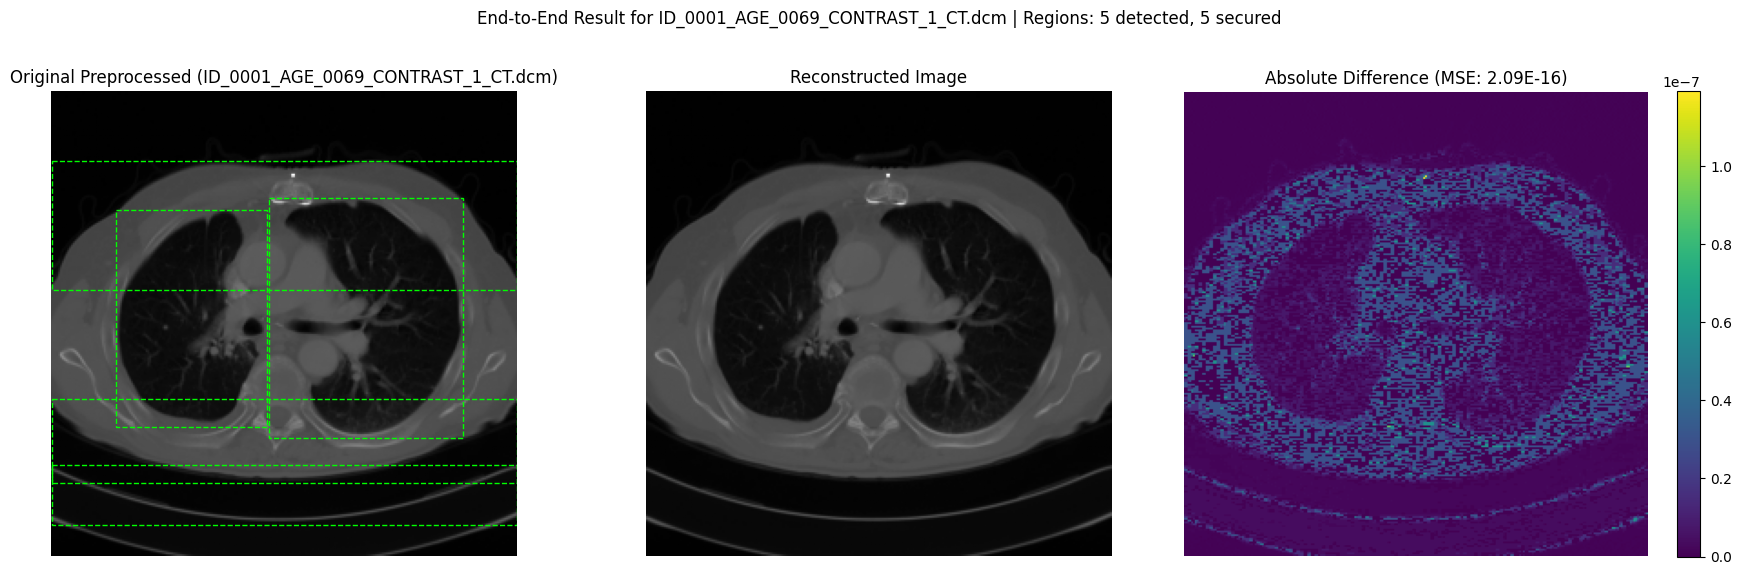

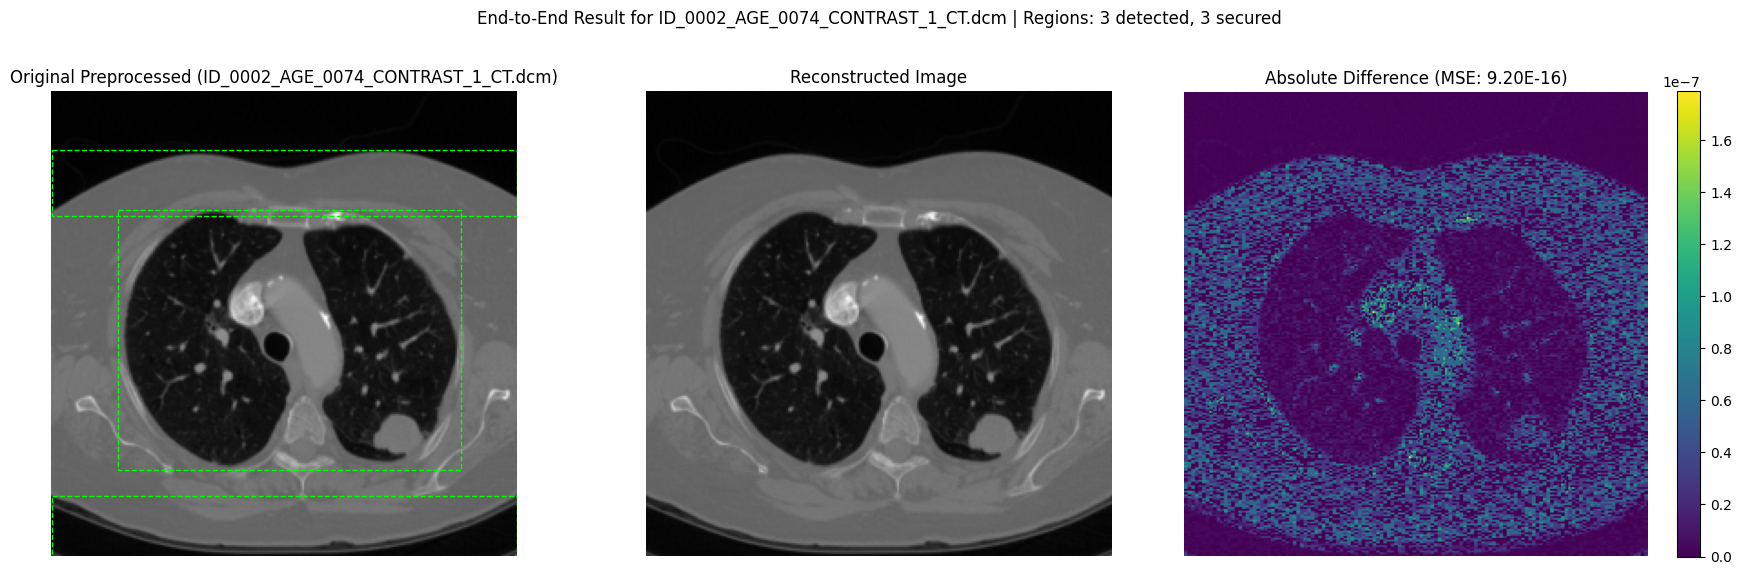


--- Summary Metrics --- (Lower MSE, Higher PSNR/SSIM are better)
+-------------+------------------------------------+---------+------------------+-----------------+-----------------------+---------------------+------------+--------+--------+----------+
| image_index |              filename              |  status | regions_detected | regions_secured | verification_failures | decryption_failures |    MSE     |  PSNR  |  SSIM  | time_sec |
+-------------+------------------------------------+---------+------------------+-----------------+-----------------------+---------------------+------------+--------+--------+----------+
|      0      | ID_0000_AGE_0060_CONTRAST_1_CT.dcm | Success |        2         |        2        |           0           |          0          | 7.0297E-16 | 151.53 | 1.0000 |   0.73   |
|      1      | ID_0001_AGE_0069_CONTRAST_1_CT.dcm | Success |        5         |        5        |           0           |          0          | 2.0929E-16 | 156.79 | 1.0000 |   1.6

In [53]:
if __name__ == "__main__":
    if metadata is None or metadata.empty:
        print("Metadata not loaded or empty. Cannot process images.")
    else:
        print("Starting main processing pipeline with Parallel Execution...")

        results_list = []
        visualizations_to_plot = []
        num_images_to_process = 100
        num_images_to_display = 3

        start_total_time = time.time()
        falcon_sk, falcon_pk = generate_falcon_keys()
        if falcon_sk is None or falcon_pk is None:
            print("Failed to generate Falcon keys. Exiting.")
            exit()
        else:
            print(f"Generated Falcon-{FALCON_N} keys successfully.")

        tasks_args = []
        for idx, row in metadata.head(num_images_to_process).iterrows():
            tasks_args.append((idx, row, dicom_dir, TARGET_SIZE, WAVELET, falcon_sk, falcon_pk, num_images_to_display))

        print(f"Submitting {len(tasks_args)} image processing tasks to ThreadPoolExecutor...")
        with concurrent.futures.ThreadPoolExecutor(max_workers=None) as executor:
            futures = [executor.submit(process_parallelization, args) for args in tasks_args]

            for future in concurrent.futures.as_completed(futures):
                try:
                    result, vis_data = future.result()
                    if result:
                        results_list.append(result)
                    if vis_data:
                        visualizations_to_plot.append(vis_data)
                except Exception as e:
                    print(f"******** ERROR retrieving result from a future: {e} ********")
                    import traceback
                    traceback.print_exc()

        end_total_time = time.time()
        total_time = end_total_time - start_total_time
        num_processed = len(results_list)
        avg_time = total_time / num_processed if num_processed > 0 else 0
        print(f"\n--- Total Processing Time for {num_processed}/{num_images_to_process} images: {total_time:.2f}s ({avg_time:.2f}s/image avg using parallel execution) ---")

        results_list.sort(key=lambda x: x.get('image_index', -1))
        visualizations_to_plot.sort(key=lambda x: x.get('idx', -1))

        print(f"\n--- Generating {len(visualizations_to_plot)} Visualizations ---")
        for vis_data in visualizations_to_plot:
            try:
                metrics = vis_data['metrics']
                regions = vis_data['regions']
                plt.figure(figsize=(18, 6))

                plt.subplot(1, 3, 1)
                plt.title(f"Original Preprocessed ({vis_data['filename']})")
                plt.imshow(vis_data['original'], cmap='gray')
                for (x, y, w, h) in regions:
                     rect = plt.Rectangle((x, y), w, h, linewidth=1, edgecolor='lime', facecolor='none', linestyle='--')
                     plt.gca().add_patch(rect)
                plt.axis('off')

                plt.subplot(1, 3, 2)
                plt.title("Reconstructed Image")
                reconstructed_display = np.clip(vis_data['reconstructed'], 0.0, 1.0)
                plt.imshow(reconstructed_display, cmap='gray')
                plt.axis('off')

                diff_image = np.abs(vis_data['original'].astype(np.float32)/255.0 - reconstructed_display)
                plt.subplot(1, 3, 3)
                plt.title(f"Absolute Difference (MSE: {metrics['MSE']:.2E})")
                im = plt.imshow(diff_image, cmap='viridis', vmin=0, vmax=np.max(diff_image) if np.max(diff_image) > 0 else 0.1)
                plt.colorbar(im)
                plt.axis('off')

                plt.suptitle(f"End-to-End Result for {vis_data['filename']} | Regions: {len(regions)} detected, {vis_data['regions_secured']} secured")
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])
                plt.show()
            except Exception as e:
                 print(f"Error generating plot for image {vis_data.get('idx', 'N/A')} ({vis_data.get('filename', 'N/A')}): {e}")


        if results_list:
            valid_results = [res for res in results_list if res.get('status') == 'Success']
            if not valid_results:
                 print("\nNo images were successfully processed to generate summary metrics.")
            else:
                results_table = PrettyTable()
                field_names = ['image_index', 'filename', 'status', 'regions_detected', 'regions_secured',
                               'verification_failures', 'decryption_failures', 'MSE', 'PSNR', 'SSIM', 'time_sec']
                results_table.field_names = field_names

                for res in results_list:
                    row_data = []
                    for field in field_names:
                        value = res.get(field, 'N/A')
                        if isinstance(value, float):
                            if field == 'MSE':
                                formatted_value = f"{value:.4E}"
                            elif field in ['PSNR', 'time_sec']:
                                formatted_value = f"{value:.2f}" if value != float('inf') else str(value)
                            elif field == 'SSIM':
                                 formatted_value = f"{value:.4f}"
                            else:
                                formatted_value = str(value)
                        else:
                            formatted_value = str(value)
                        row_data.append(formatted_value)
                    results_table.add_row(row_data)

                print("\n--- Summary Metrics --- (Lower MSE, Higher PSNR/SSIM are better)")
                print(results_table)
        else:
            print("\nNo image results were collected.")